# 1. Import and Install Dependencies

In [2]:
!pip install tensorflow opencv-python mediapipe

   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   -----------------

In [5]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 6. Preprocess Data and Create Labels and Features

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
# label_map = {label:num for num, label in enumerate(actions)}
import numpy as np

actions = np.array([
    'ا','ب','ت','ث','ج','ح','خ','د','ذ','ر','ز',
    'س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك',
    'ل','م','ن','هـ','و','ي'
])

label_map = {label: idx for idx, label in enumerate(actions)}
label_map


{'ا': 0,
 'ب': 1,
 'ت': 2,
 'ث': 3,
 'ج': 4,
 'ح': 5,
 'خ': 6,
 'د': 7,
 'ذ': 8,
 'ر': 9,
 'ز': 10,
 'س': 11,
 'ش': 12,
 'ص': 13,
 'ض': 14,
 'ط': 15,
 'ظ': 16,
 'ع': 17,
 'غ': 18,
 'ف': 19,
 'ق': 20,
 'ك': 21,
 'ل': 22,
 'م': 23,
 'ن': 24,
 'هـ': 25,
 'و': 26,
 'ي': 27}

In [9]:
import os
import numpy as np

DATA_PATH = 'MP_Data/Alphabets'

# بدل الحروف → 0…27
actions = [str(i) for i in range(28)]

# عدد الفيديوهات لكل حرف
no_sequences = 100     # حسب دمج البنات
sequence_length = 90   # حسب التصوير

# خريطة labels
label_map = {label: int(label) for label in actions}

sequences, labels = [], []

for action in actions:
    for sequence in range(no_sequences):
        window = []
        valid = True

        for frame_num in range(sequence_length):

            path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")

            if not os.path.exists(path):
                print(f"⚠️ Missing frame: {path}")
                valid = False
                break

            res = np.load(path)
            window.append(res)

        if valid:
            sequences.append(window)
            labels.append(label_map[action])


⚠️ Missing frame: MP_Data/Alphabets\3\73\0.npy
⚠️ Missing frame: MP_Data/Alphabets\3\74\0.npy


In [10]:
np.array(sequences).shape

(2798, 90, 42)

In [11]:
np.array(labels).shape

(2798,)

In [14]:
X = np.array(sequences)

In [12]:
y = to_categorical(labels).astype(int)

In [25]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [16]:
y_train.shape

(2238, 28)

# 7. Build and Train LSTM Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)
tb_callback = TensorBoard(
    log_dir=log_dir,
    update_freq="epoch"   # <— هذا يجعل الكتابة مرة واحدة بس
)


In [44]:
model = Sequential()

# LSTM Layers
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(90, 42)))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))

# Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(28, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 128)           87552     
                                                                 
 lstm_3 (LSTM)               (None, 90, 256)           394240    
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 28)               

In [45]:
# res = [.7, 0.2, 0.1]
print(X_train.shape)
print(y_train.shape)


(2238, 90, 42)
(2238, 28)


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras import backend as K

# تنظيف أي موديل سابق
K.clear_session()

# الأبعاد من الداتا (بدون أخطاء)
TIMESTEPS   = X_train.shape[1]     # 90
FEAT_DIM    = X_train.shape[2]     # 42
NUM_CLASSES = y_train.shape[1]     # 28

# بناء الموديل
model = Sequential()

model.add(Input(shape=(TIMESTEPS, FEAT_DIM)))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(NUM_CLASSES, activation='softmax'))

# تجميع الموديل
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 256)           306176    
                                                                 
 dropout (Dropout)           (None, 90, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 28)                3

In [ ]:
class_weights = {
    0: 1.5,
    1: 1.5,
    2: 2.0,   # حرف مهم → وزن أعلى
    3: 1.0,   # حرف نادر → وزن عالي
    4: 1.0,
    5: 1.2,
    6: 1.0,
    7: 1.0,
    8: 2.0,
    9: 2.5,
    10: 1.0,
    11: 2.5,
    12: 2.5,
    13: 1.0,
    14: 1.0,
    15: 3.5,
    16: 1.0,
    17: 1.0,
    18: 2.0,
    19: 1.0,
    20: 1.0,
    21: 2.5,
    22: 1.0,
    23: 1.0,
    24: 1.0,
    25: 1.0,
    26: 1.5,
    27: 1.0,
}


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

# ===== TensorBoard (اختياري بس مفيد جداً) =====
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir)

# ===== Early Stopping =====
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# ===== Learning Rate Scheduler =====
reduce_lr  = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)

# ===== Training =====
history = model.fit(
    X_train, y_train,
    epochs=180,
    batch_size=32,
    validation_split=0.2,
    # callbacks=[tb_callback, early_stop, reduce_lr],
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weights
)


Epoch 1/180
56/56 [==============================] - 122s 2s/step - loss: 4.7215 - accuracy: 0.0547 - val_loss: 3.1864 - val_accuracy: 0.1071 - lr: 5.0000e-04
Epoch 2/180
56/56 [==============================] - 118s 2s/step - loss: 4.0235 - accuracy: 0.1095 - val_loss: 2.7505 - val_accuracy: 0.1295 - lr: 5.0000e-04
Epoch 3/180
56/56 [==============================] - 95s 2s/step - loss: 3.2021 - accuracy: 0.2117 - val_loss: 3.1176 - val_accuracy: 0.0871 - lr: 5.0000e-04
Epoch 4/180
56/56 [==============================] - 57s 1s/step - loss: 3.1222 - accuracy: 0.1922 - val_loss: 2.2171 - val_accuracy: 0.2165 - lr: 5.0000e-04
Epoch 5/180
56/56 [==============================] - 85s 2s/step - loss: 2.5830 - accuracy: 0.2788 - val_loss: 2.2348 - val_accuracy: 0.2098 - lr: 5.0000e-04
Epoch 6/180
56/56 [==============================] - 88s 2s/step - loss: 2.8904 - accuracy: 0.2631 - val_loss: 1.7423 - val_accuracy: 0.3594 - lr: 5.0000e-04
Epoch 7/180
56/56 [==============================]

In [48]:
model.save("model_weight_train.h5")


In [49]:
from tensorflow.keras.models import load_model
model = load_model('model_weight_train.h5')

# 8. Make Predictions

In [ ]:
# res = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 633ms/step


# 9. Save Weights

In [37]:
model.save('action_f2.h5')

In [23]:
del model

In [38]:
from tensorflow.keras.models import load_model
model = load_model('action_f2.h5')


# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
# yhat = model.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 481ms/step


In [ ]:
# ytrue = np.argmax(y_test, axis=1).tolist()
# yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
#multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 2]],

       [[2, 0],
        [0, 1]]], dtype=int64)

In [ ]:
#accuracy_score(ytrue, yhat)

1.0

# 11. Test in Real Time

In [69]:
import random
import cv2
import numpy as np

# توليد ألوان بعدد الأحرف (28)
colors = [(random.randint(50,255), random.randint(50,255), random.randint(50,255)) 
          for _ in range(len(actions))]

def prob_viz(res, actions, input_frame, colors, bbox=None):
    output_frame = input_frame.copy()

    # ======================
    # 1) رسم احتمالات أعلى 5
    # ======================
    top_indices = np.argsort(res)[-5:][::-1]

    for idx, action_i in enumerate(top_indices):
        prob  = res[action_i]
        color = colors[action_i]

        cv2.rectangle(output_frame,
                      (0, 60 + idx * 40),
                      (int(prob * 300), 90 + idx * 40),
                      color,
                      -1)

        cv2.putText(output_frame,
                    f"{actions[action_i]}: {prob:.2f}",
                    (10, 85 + idx * 40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    (255,255,255),
                    2,
                    cv2.LINE_AA)

    # ======================
    # 2) رسم مربع حول اليد
    # ======================
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(output_frame, (x1, y1), (x2, y2), (0,255,0), 3)

        # أعلا المربع نكتب الحرف
        main_pred = actions[np.argmax(res)]
        cv2.putText(output_frame,
                    main_pred,
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.2,
                    (0,255,0),
                    3,
                    cv2.LINE_AA)

    return output_frame


In [3]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# Load Model
model = load_model('model_weight_train.h5')

# Labels
actions = np.array([
    'a', 'b', 't', 'th', 'j', '7', 'kh', 'd', 'dh', 'r', 'z',
    's', 'sh', 'sad', 'dad', 'tah', 'zah', '3', 'gh', 'f', 'q',
    'k', 'l', 'm', 'n', 'h', 'w', 'y'
])

# ================================
# Mediapipe setup
# ================================
mp_hands   = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles  = mp.solutions.drawing_styles

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# ================================
# Extract RAW 42 features (NO NORMALIZATION)
# ================================
def extract_keypoints(results):
    if not results.multi_hand_landmarks:
        return np.zeros(42, dtype=np.float32)

    hand = results.multi_hand_landmarks[0]

    pts = []
    for lm in hand.landmark:
        pts.append(lm.x)    # raw X
        pts.append(lm.y)    # raw Y

    return np.array(pts, dtype=np.float32)

# ================================
# Draw landmarks
# ================================
def mediapipe_detection(image, model):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(img)
    return image, results

def draw_landmarks(image, results):
    if results.multi_hand_landmarks:
        for hand in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand, mp_hands.HAND_CONNECTIONS,
                mp_styles.get_default_hand_landmarks_style(),
                mp_styles.get_default_hand_connections_style()
            )

# ================================
# Probability bars (Top-5)
# ================================
colors = [tuple(np.random.randint(50,255,3).tolist()) for _ in range(len(actions))]

def prob_viz(res, actions, image):
    output = image.copy()

    top_idx = np.argsort(res)[-5:][::-1]

    for i, idx in enumerate(top_idx):
        prob = res[idx]
        color = colors[idx]

        cv2.rectangle(
            output, (0, 60+i*40),
            (int(prob*300), 95+i*40),
            color, -1
        )

        cv2.putText(
            output,
            f"{actions[idx]} {prob:.2f}",
            (10, 90+i*40),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (255,255,255), 2
        )

    return output

# ================================
# LSTM sequence
# ================================
SEQ_LEN = 90
sequence = []
sentence = []
threshold = 0.7

cap = cv2.VideoCapture(0)

# ================================
# MAIN LOOP
# ================================
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    H, W, _ = frame.shape

    image, results = mediapipe_detection(frame, hands)
    draw_landmarks(image, results)

    # Extract features
    keypoints = extract_keypoints(results)
    sequence.append(keypoints)
    sequence = sequence[-SEQ_LEN:]

    # Bounding box
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        xs = [lm.x for lm in hand.landmark]
        ys = [lm.y for lm in hand.landmark]

        x1 = int(min(xs) * W) - 20
        y1 = int(min(ys) * H) - 20
        x2 = int(max(xs) * W) + 20
        y2 = int(max(ys) * H) + 20
    else:
        x1=y1=x2=y2 = 0

    # Prediction
    if len(sequence) == SEQ_LEN:
        res = model.predict(
            np.expand_dims(sequence, axis=0),
            verbose=0
        )[0]

        pred = actions[np.argmax(res)]

        if res[np.argmax(res)] > threshold:
            if len(sentence) == 0 or pred != sentence[-1]:
                sentence.append(pred)

            if len(sentence) > 5:
                sentence = sentence[-5:]

        image = prob_viz(res, actions, image)

        # BOX + LABEL
        cv2.rectangle(image, (x1, y1-40), (x2, y1), (0,0,0), -1)
        cv2.putText(
            image, pred,
            (x1+10, y1-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.2, (255,255,255), 3
        )
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,0), 3)

    # Sentence Bar
    cv2.rectangle(image, (0,0), (640,40), (0,0,0), -1)
    cv2.putText(image, ' '.join(sentence), (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255,255,255), 2)

    cv2.imshow("Sign Detection", image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


d:\movment_detection_model\.venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [ ]:
# كود عمل الجمل 
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import time

# Load Model
model = load_model('model_weight_train.h5')

# Labels
actions = np.array([
    'a', 'b', 't', 'th', 'j', '7', 'kh', 'd', 'dh', 'r', 'z',
    's', 'sh', 'sad', 'dad', 'tah', 'zah', '3', 'gh', 'f', 'q',
    'k', 'l', 'm', 'n', 'h', 'w', 'y'
])

# ================================
# Arabic Mapping for Terminal Output
# ================================
arabic_map = {
    "a": "ا",
    "b": "ب",
    "t": "ت",
    "th": "ث",
    "j": "ج",
    "7": "ح",
    "kh": "خ",
    "d": "د",
    "dh": "ذ",
    "r": "ر",
    "z": "ز",
    "s": "س",
    "sh": "ش",
    "sad": "ص",
    "dad": "ض",
    "tah": "ط",
    "zah": "ظ",
    "3": "ع",
    "gh": "غ",
    "f": "ف",
    "q": "ق",
    "k": "ك",
    "l": "ل",
    "m": "م",
    "n": "ن",
    "h": "ه",
    "w": "و",
    "y": "ي"
}

# ================================
# Mediapipe setup
# ================================
mp_hands   = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles  = mp.solutions.drawing_styles

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# ================================
# Extract RAW 42 features
# ================================
def extract_keypoints(results):
    if not results.multi_hand_landmarks:
        return np.zeros(42, dtype=np.float32)

    hand = results.multi_hand_landmarks[0]

    pts = []
    for lm in hand.landmark:
        pts.append(lm.x)
        pts.append(lm.y)

    return np.array(pts, dtype=np.float32)

# ================================
# Drawing
# ================================
def mediapipe_detection(image, model):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(img)
    return image, results

def draw_landmarks(image, results):
    if results.multi_hand_landmarks:
        for hand in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand, mp_hands.HAND_CONNECTIONS,
                mp_styles.get_default_hand_landmarks_style(),
                mp_styles.get_default_hand_connections_style()
            )

# ================================
# Probability bars
# ================================
colors = [tuple(np.random.randint(50,255,3).tolist()) for _ in range(len(actions))]

def prob_viz(res, actions, image):
    output = image.copy()
    top_idx = np.argsort(res)[-5:][::-1]

    for i, idx in enumerate(top_idx):
        prob = res[idx]
        color = colors[idx]

        cv2.rectangle(output, (0, 60+i*40), (int(prob*300), 95+i*40), color, -1)
        cv2.putText(output, f"{actions[idx]} {prob:.2f}", (10, 90+i*40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    return output

# ================================
# Variables
# ================================
SEQ_LEN = 90
sequence = []

stable_letter = None
stable_start_time = None

writing_text = ""
last_added_letter = ""
terminal_sentence = ""   # Arabic for terminal

cap = cv2.VideoCapture(0)

# ================================
# MAIN LOOP
# ================================
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    H, W, _ = frame.shape

    image, results = mediapipe_detection(frame, hands)
    draw_landmarks(image, results)

    keypoints = extract_keypoints(results)
    sequence.append(keypoints)
    sequence = sequence[-SEQ_LEN:]

    # Bounding box
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        xs = [lm.x for lm in hand.landmark]
        ys = [lm.y for lm in hand.landmark]

        x1 = int(min(xs) * W) - 20
        y1 = int(min(ys) * H) - 20
        x2 = int(max(xs) * W) + 20
        y2 = int(max(ys) * H) + 20
    else:
        x1=y1=x2=y2 = 0

    # Prediction
    if len(sequence) == SEQ_LEN:
        res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]

        pred = actions[np.argmax(res)]
        prob = res[np.argmax(res)]

        image = prob_viz(res, actions, image)

        # Draw box
        cv2.rectangle(image, (x1, y1-40), (x2, y1), (0,0,0), -1)
        cv2.putText(image, pred, (x1+10, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,0), 3)

        # Stable 3 seconds
        if prob > 0.90:
            if stable_letter != pred:
                stable_letter = pred
                stable_start_time = time.time()
            else:
                elapsed = time.time() - stable_start_time
                if elapsed >= 3:

                    if pred != last_added_letter:
                        # Add to English writing
                        writing_text += pred

                        # Convert to Arabic
                        arabic_letter = arabic_map.get(pred, pred)
                        terminal_sentence += arabic_letter

                        print(f"تم إضافة: {terminal_sentence}")

                        last_added_letter = pred

                    stable_letter = None
                    stable_start_time = None
        else:
            stable_letter = None
            stable_start_time = None

    # SPACE = add space
    key = cv2.waitKey(10)
    if key == ord(' '):
        writing_text += " "
        terminal_sentence += " "
        last_added_letter = ""
        print(f"تم إضافة: {terminal_sentence}")

    elif key == ord('q'):
        break

    # Display writing text
    cv2.rectangle(image, (0,0), (640,40), (0,0,0), -1)
    cv2.putText(image, writing_text, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    cv2.imshow("Sign Detection", image)

cap.release()
cv2.destroyAllWindows()


تم إضافة: ع
تم إضافة: عب
تم إضافة: عبد
تم إضافة: عبد 
تم إضافة: عبد ا
تم إضافة: عبد ال
تم إضافة: عبد الب
تم إضافة: عبد البا
تم إضافة: عبد الباس
تم إضافة: عبد الباسط


In [50]:
# تقييم الموديل على بيانات التدريب
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")

# تقييم الموديل على بيانات الاختبار
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Testing Accuracy: {test_acc * 100:.2f}%")


✅ Training Accuracy: 99.51%
✅ Testing Accuracy: 98.57%


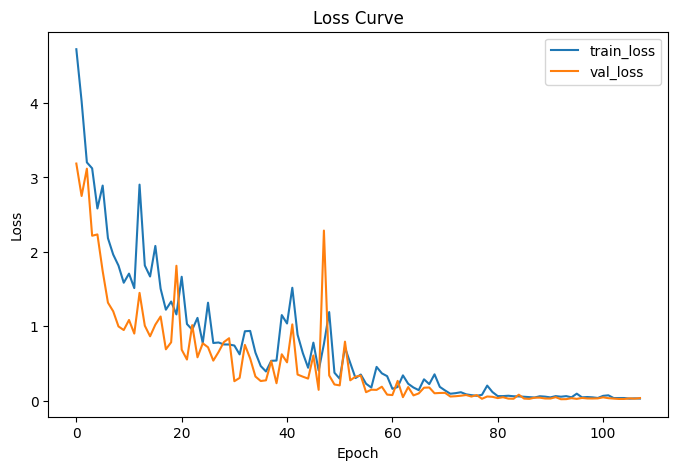

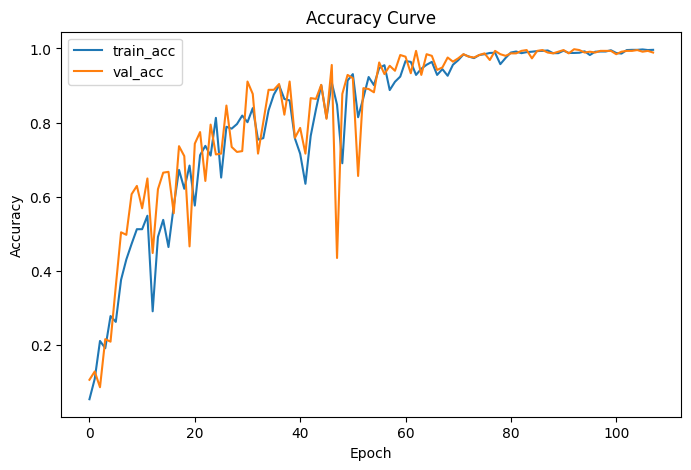

In [51]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
